In [174]:
import requests
from tqdm import tqdm
from os.path import join as oj
import tables, numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
import pickle as pkl
from skimage.util import img_as_float
import h5py
from copy import deepcopy
from skimage.filters import gabor_kernel
import gabor_feats
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
plt.style.use('dark_background')
from run import *
out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'

# look at model fits

In [135]:
rois = ['v1lh', 'v1rh', 'v2lh', 'v2rh', 'v4lh', 'v4rh']
save_dir = oj(out_dir, 'mot_energy8')
fnames = sorted([fname for fname in os.listdir(save_dir)])
results_list = [pd.Series(pkl.load(open(oj(save_dir, fname), "rb"))) for fname in tqdm(fnames) ]
results = pd.concat(results_list, axis=1).T.infer_objects()
results['region'] = results['roi'].str.slice(0, 2)
r = results.drop('model', axis=1) # drop model to speed things up
r = r[np.isnan(r.corr_test)]

100%|██████████| 157/157 [00:00<00:00, 785.02it/s]
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [136]:
r.head()

,complexity1,complexity2,corr,corr_test,d,idx,mse,mse_test,mse_train,n_test,...,num_train,r2,r2_test,r2_train,roi,term1,term2,term3,term4,region
0,1.419542,1.557099,0.058971,NaN,6555,13290,1.027862,NaN,0.778724,NaN,...,7200.0,-0.027863,NaN,0.221276,v2lh,0.0,10220.701993,11089.766312,121.344448,v2
1,1.454413,1.597393,0.019467,NaN,6555,13349,1.005382,NaN,0.953714,NaN,...,7200.0,-0.005383,NaN,0.046286,v2lh,0.0,10471.775374,11382.109454,119.116890,v2
2,1.338414,1.470986,0.129833,NaN,6555,13350,0.983155,NaN,0.918418,NaN,...,7200.0,0.016845,NaN,0.081581,v2lh,0.0,9636.582645,10454.896232,136.204910,v2
3,1.263262,1.377859,0.102166,NaN,6555,13351,1.049658,NaN,0.688383,NaN,...,7200.0,-0.049658,NaN,0.311617,v2lh,0.0,9095.488845,9759.059905,161.525125,v2
4,1.383341,1.516532,-0.028278,NaN,6555,13352,1.076778,NaN,0.782133,NaN,...,7200.0,-0.076779,NaN,0.217867,v2lh,0.0,9960.054636,10785.019366,134.012312,v2


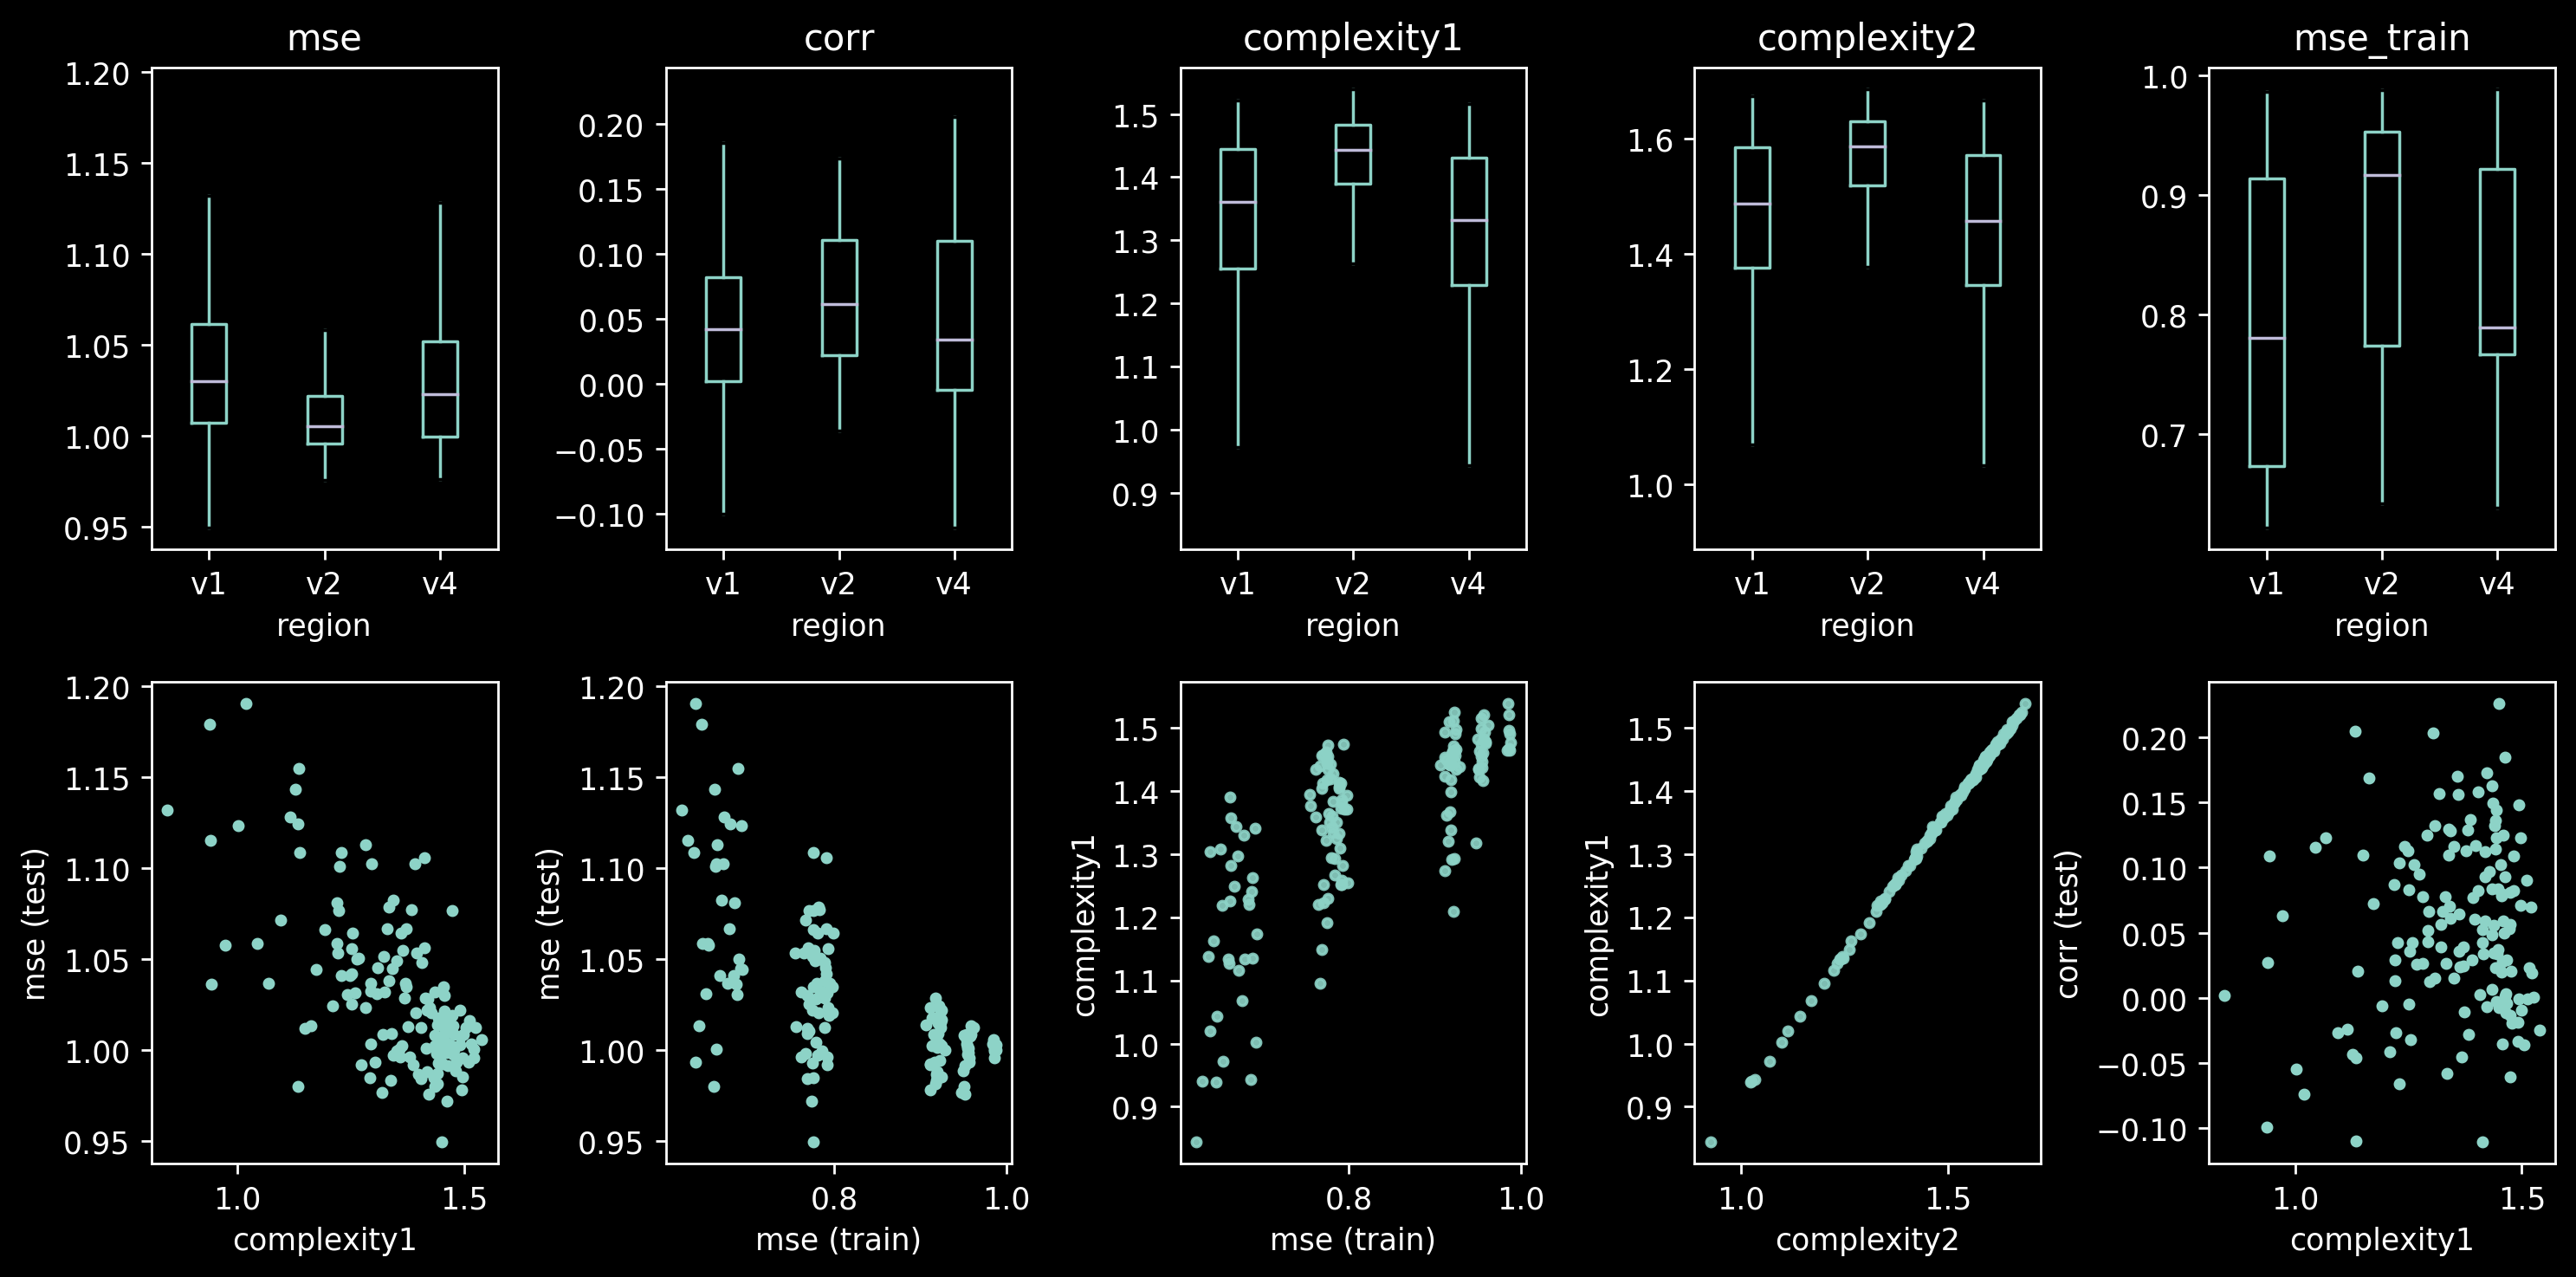

In [176]:
cols = ['mse', 'corr', 'complexity1', 'complexity2', 'mse_train']
f, axes = plt.subplots(2, 5, figsize=(12, 6), dpi=250)
axes = axes.flatten()
for i, col in enumerate(cols):
    # plt.subplot(R, C, 1)
    r.boxplot(by='region', column=col, ax=axes[i], grid=False)

ax = axes[i + 1]
ax.plot(r['complexity1'], r['mse'], '.')
ax.set_xlabel('complexity1')
ax.set_ylabel('mse (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_train'], r['mse'], '.')
ax.set_xlabel('mse (train)')
ax.set_ylabel('mse (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_train'], r['complexity1'], '.', alpha=0.9)
ax.set_xlabel('mse (train)')
ax.set_ylabel('complexity1')
i += 1

ax = axes[i + 1]
ax.plot(r['complexity2'], r['complexity1'], '.', alpha=0.9)
ax.set_xlabel('complexity2')
ax.set_ylabel('complexity1')
i += 1

ax = axes[i + 1]
ax.plot(r['complexity1'], r['corr'], '.')
ax.set_xlabel('complexity1')
ax.set_ylabel('corr (test)')
i += 1

plt.suptitle('')
plt.tight_layout()
plt.show()

In [141]:
alphas = []
for i in range(results.shape[0]):
    alphas.append(results.model.iloc[i].alpha_)
np.unique(alphas, return_counts=True)

(array([  5000.,  10000.,  50000., 100000., 500000.]),
 array([33, 57, 37, 21,  9]))

# basic viz

In [182]:
idxs = r.idx.values
vals = r.complexity1
vol = np.zeros(73728) * np.nan
vol[idxs] = vals
vol = vol.reshape(18, 64, 64)
vol = vol.transpose()

In [201]:
print(vol.shape, np.nansum(vol), np.nansum(np.nansum(vol, axis=0), axis=0), np.nanmin(vol), np.nanmax(vol))

(64, 64, 18) 205.21182331519094 [ 0.         14.42899443 39.82257826 51.77111804 66.64216595  2.11136598
  8.67157927 21.76402138  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 0.8448870103739263 1.539031418851919


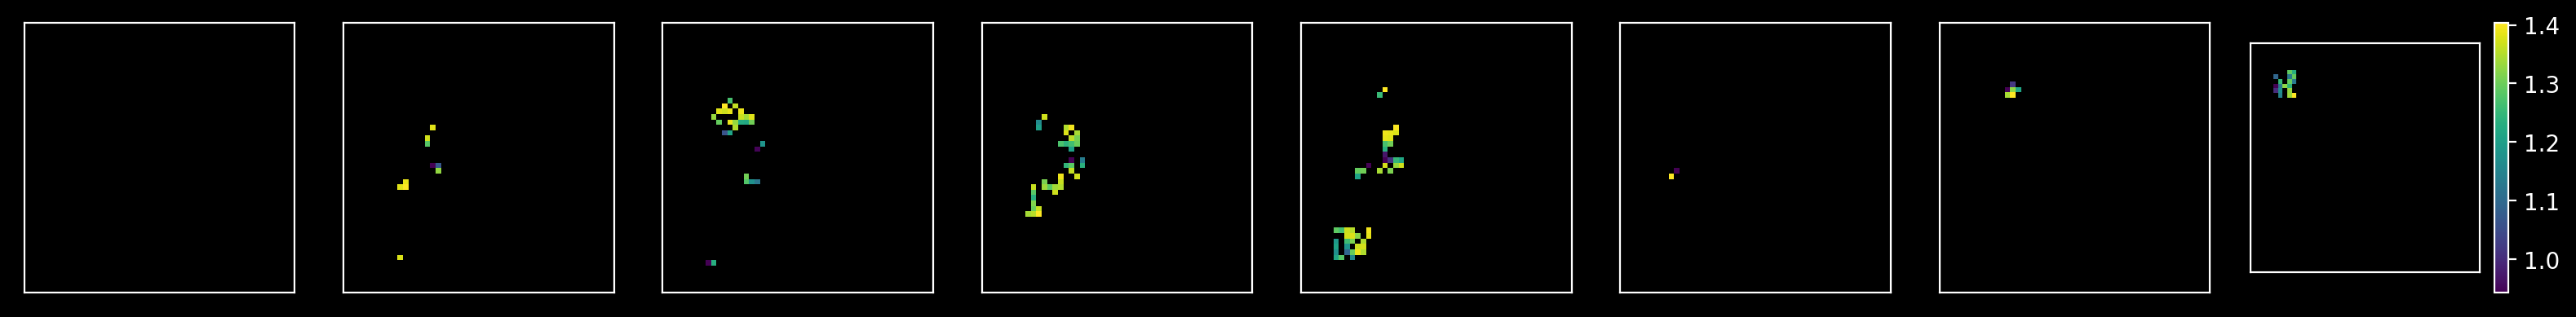

In [211]:
R, C = 1, 8
plt.figure(figsize=(C * 2, R * 2), dpi=200)
vmin = np.nanmin(vol)
vmax = np.nanmax(vol)
for i in range(8):
    plt.subplot(R, C, i + 1)
    NUM = 7
    plt.imshow(vol[NUM: -NUM, NUM: -NUM, i]) #, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()
# plt.imshow(vol[:, :, 15])

(64, 64, 18, 3)


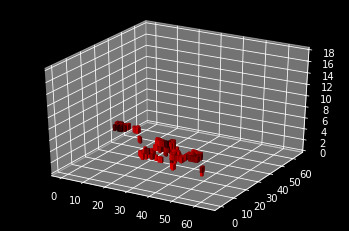

In [230]:
voxels = ~np.isnan(vol)
colors = vol
colors = (colors - np.nanmin(colors)) / (np.nanmax(colors) - np.nanmin(colors))
s = colors.shape
colors = colors.reshape((s[0], s[1], s[2], 1))
colors = colors.repeat(axis=-1, repeats=3)
colors[..., 1:] = 0
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors) #, edgecolor='k')

plt.show()

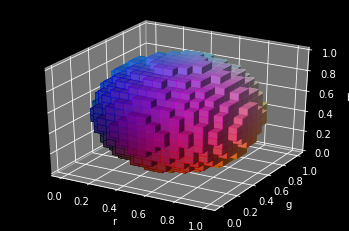

In [217]:
import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b')

plt.show()

In [ ]:
colors

# pycortex

In [37]:
import nibabel as nib
import cortex
from cortex import surfs


img = nib.load(anat_file)
im_np = np.array(img.get_fdata())
im_np.shape

anat_file = oj(out_dir, 'anatomy/S1_anatomy.nii')
ret_file = 'S1_retinotopy.hdf'
ds = cortex.load(ret_file)

In [ ]:
im = cortex.quickshow((np.random.randn(31, 100, 100), "S1", "fullhead"))

In [ ]:
cortex.webshow(ds)

In [ ]:
dv = cortex.Volume(anat_file, "S1", "fullhead")

In [ ]:
cortex.quickshow(im_np, "S1", "fullhead")

In [ ]:
cortex.webshow(img)

In [ ]:
ds = cortex.load("S1_retinotopy.hdf")

In [40]:
!h5ls S1_retinotopy.hdf

/bin/sh: 1: h5ls: not found


In [ ]:
cortex.webshow(cortex.Volume.random("S1", "fullhead"))

In [ ]:
pts, poly = surfs.getSurf("AH", "fiducial", merge=True)

# nilearn plotting

In [40]:
x = np.random.randn(64, 64, 18)

In [41]:
from nilearn import plotting, datasets

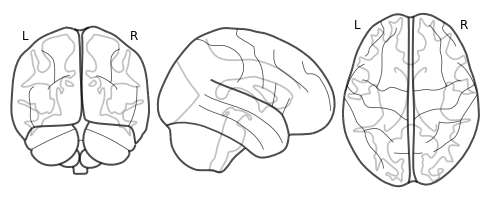

In [44]:
plotting.plot_glass_brain(None) #, annotate=False, black_bg=True)

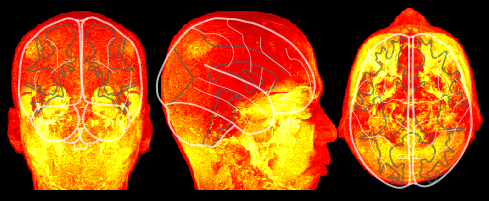

In [32]:
plotting.plot_glass_brain(anat_file, annotate=False, black_bg=True)

In [56]:
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]
# stat_img is just the name of the file that we downloded
stat_img


Dataset created in /accounts/projects/vision/nilearn_data/neurovault



'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'

In [58]:
stat_img

'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'